# Jugend Forscht 
## Datenanalyse selbst gesammelter Daten 10.02.2024

Zunächst laden wir die Dependencies...

In [2]:
import subprocess
import time
import json
import matplotlib.pyplot as plt 
import csv 
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns  
import pickle
from itertools import islice
from scipy.cluster.vq import kmeans
from scipy.cluster.vq import vq

In [3]:
# DIR-PATHS
avg_fee_block_path = '/home/oscar/jufobtc/data/fees_750.csv'
mempool_tx_path = '/home/oscar/jufobtc/data/mem_tx.csv'
fee_comp_path = '/home/oscar/jufobtc/data/fee_estimator_comp.csv'
tx_times_path = '/home/oscar/jufobtc/data/tx_times.csv'

... und die Daten.

In [4]:
# LOAD DATA

avg_fee_block = open(avg_fee_block_path, 'r')
col = ['timestamp', 'blockheight', 'avg_fee']
df_avg_fee = pd.read_csv(avg_fee_block, delimiter=' ', names=col)



mempool_tx = open(mempool_tx_path, 'r')
col = ['txhash', 'timestamp']
df_mempool_tx = pd.read_csv(mempool_tx, delimiter=' ', names=col)


fee_comp = open(fee_comp_path, 'r')
col = ['blockheight', 'mem.space_est', 'bitcoincore_est', 'wtfee_est', 'timestamp'] # blockheight steht für den block, für den die Prognose ist
df_fee_comp = pd.read_csv(fee_comp, delimiter=' ', names=col)

tx_times = open(tx_times_path, 'r')
col = ['txhash', 'difftime', 'blockheight']
df_tx_times = pd.read_csv(tx_times, names=col, delimiter=' ')



### Zusammenführung der Daten
Nun mergen wir die Datensätze A Vergleich der Gebührenvorhersage und B der durchschnittlichen Gebühren. Außerdem droppen wir alle Einträge bis auf den letzten vor der Bestätigung des nächsten Blockes. Demnach haben wir immer die aktuellste Vorhersage.

In [5]:
#MERGE DATA
df_fee_comp = pd.merge(df_fee_comp, df_avg_fee, on='blockheight')
df_fee_comp = df_fee_comp.drop_duplicates("blockheight", keep='last')
#print(df_fee_comp)

### Berechnungen Gebührenvorhersagen
Für eine bessere Vergleichbarkeit der Schätzungen berechnen wir noch einige Differenzen:
- Gebührenänderung  
- Änderung der Gebührenprognose  
- Blockerstellungszeiten

TODO: Differenzen zwischen den einzelnen Schätzern berechnen. 

In [ ]:
# CALCs
df_fee_comp["change_avg_fee"] = df_fee_comp["avg_fee"].diff()
df_fee_comp["change_fee_est_bitcoincore"] = df_fee_comp['bitcoincore_est'].diff()
df_fee_comp["change_fee_est_mem.space"] = df_fee_comp['mem.space_est'].diff()
df_fee_comp["change_fee_est_wtfee"] = df_fee_comp['wtfee_est'].diff()
df_fee_comp["blocktime"] = df_fee_comp["timestamp_y"].diff()

df_avg_fee["blocktime"] = df_avg_fee["timestamp"].diff()

#print(df_fee_comp.loc[df_fee_comp["change_avg_fee"] & df_fee_comp["change_avg_fee"] ])

print(df_fee_comp.head(2))

### Bereinigung des Datensatzes für Transaktionsbestätigungszeiten

1. Tx mit einer Zeit von kleiner als 0 auf 0 setzen -> bedeutet direkte Bestätigung in Block (potenzielle Ursache könnte die ungenaue Zeit im Blocktimestamp sein)
2. Abziehung der Blockerstellungszeiten von tx zeiten
   1. Merge mit Datensatz mit Gebühren und Blocktimestamps
   2. => Verminderung des Einflusses der Varianz der Blockerstellungszeiten


In [ ]:
# CALCs 2
df_tx_times["difftime"].loc[df_tx_times["difftime"]<0] = 0
df_tx_times = df_tx_times.dropna()
df_tx_times = pd.merge(df_tx_times, df_avg_fee, on="blockheight")

df_tx_times["cl_difftime"] = df_tx_times["difftime"] - df_tx_times["blocktime"]

### Berechnung der Mediane für Zeiten der Blöcke
Vorteile:
- Bessere Vergleichbarkeit   
- Vereinfachte Messungen  

Nachteile:
- Beispielsweise CPFP ist nicht berücksichtigt  

In [8]:
temp = pd.DataFrame(columns=[ "median_difftime"])
temp["median_difftime"] =  df_tx_times.groupby(['blockheight'])["cl_difftime"].median()
temp["blockheight"] = temp.index
temp.index.names = ["index"]
df_avg_fee = pd.merge(df_avg_fee, temp, on='blockheight')
#print(df_avg_fee)
                                                                                    

### Zusammenführung aller Datensätze 

In [23]:
data = pd.merge(df_avg_fee, df_fee_comp, on="blockheight")

data = data.drop(columns=["timestamp_x","avg_fee_y","blocktime_y"])

data = data.rename(columns={'blocktime_x': 'blocktime', 'timestamp_y': 'timestamp', 'avg_fee_x': 'avg_fee'})

data["blockheight"].astype(int)



829513


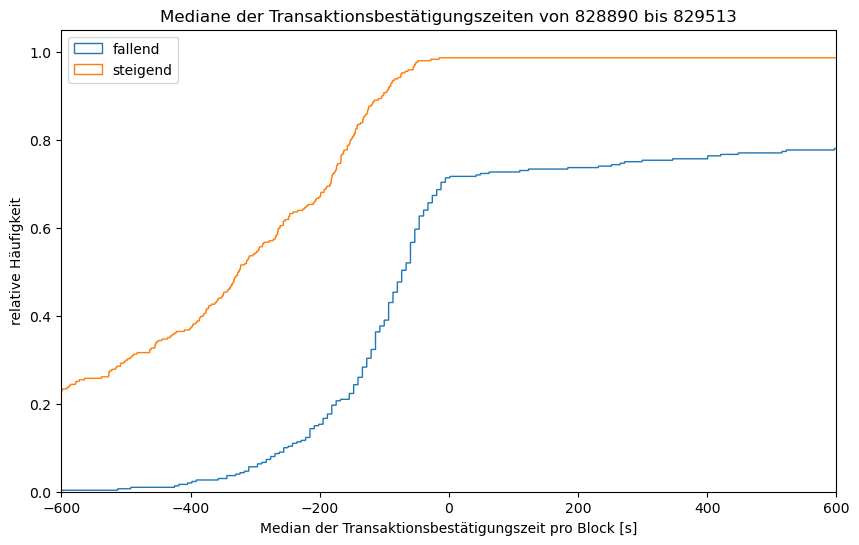

In [35]:
plt.figure(figsize=(10,6))

plt.hist(data["median_difftime"].loc[data["change_avg_fee"]<0], cumulative=True, density=True, bins=10000, label='fallend', histtype='step')
plt.hist(data["median_difftime"].loc[data["change_avg_fee"]>0], cumulative=True, density=True, bins=10000, label='steigend', histtype='step')



plt.xlim(-600, 600)

plt.ylabel('relative Häufigkeit')
plt.xlabel("Median der Transaktionsbestätigungszeit pro Block [s]")
plt.title('Mediane der Transaktionsbestätigungszeiten von {} bis {}'.format(str(data["blockheight"].min()), str(data["blockheight"].max())))
plt.legend()




Text(0, 0.5, 'durchschnitll. Transaktionsgebühr pro Block [Sat/VByte]')

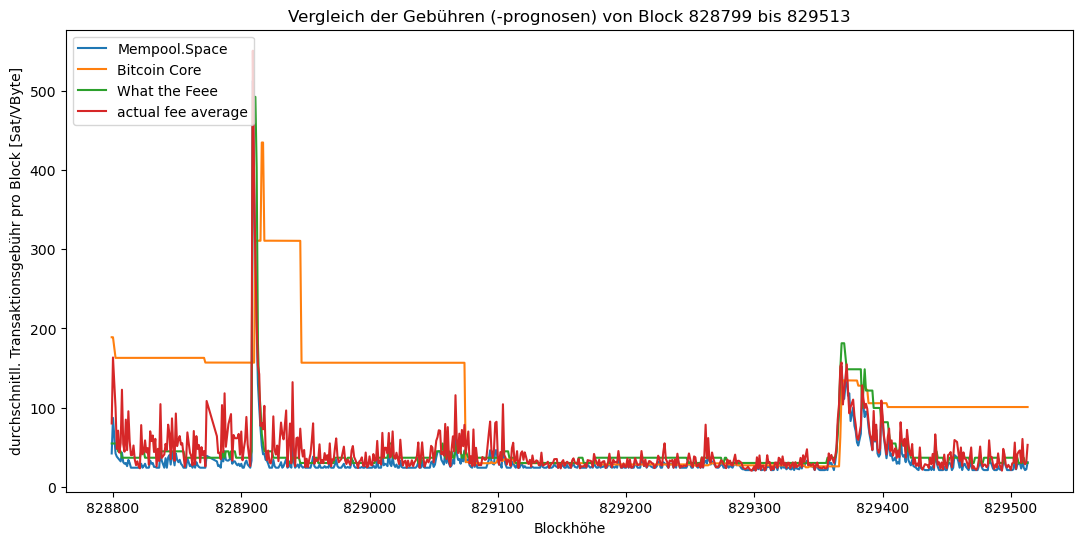

In [37]:
# OVERVIEW DATA
plt.figure(figsize=(13,6))

plt.plot(df_fee_comp["blockheight"],df_fee_comp['mem.space_est'], label='Mempool.Space')
plt.plot(df_fee_comp["blockheight"],df_fee_comp['bitcoincore_est'], label='Bitcoin Core')
plt.plot(df_fee_comp["blockheight"],df_fee_comp['wtfee_est'], label="What the Feee")
plt.plot(df_fee_comp["blockheight"],df_fee_comp["avg_fee"], label='actual fee average')

plt.legend(loc='upper left')
plt.ticklabel_format(useOffset=False)

plt.title('Vergleich der Gebühren (-prognosen) von Block {} bis {}'.format(df_fee_comp["blockheight"].min(),df_fee_comp["blockheight"].max()))
plt.xlabel('Blockhöhe')
plt.ylabel('durchschnitll. Transaktionsgebühr pro Block [Sat/VByte]')
